In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [269]:
def prepare(df):
    global json_cols
    global train_dict

    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    df['release_year'] = df['release_year']
    df.loc[ (df['release_year'] <= 19) & (df['release_year'] < 100), "release_year"] += 2000
    df.loc[ (df['release_year'] > 19)  & (df['release_year'] < 100), "release_year"] += 1900
    
    releaseDate = pd.to_datetime(df['release_date']) 
    df['release_dayofweek'] = releaseDate.dt.dayofweek 
    df['release_quarter'] = releaseDate.dt.quarter     
    
    rating_na = df.groupby(["release_year","original_language"])['rating'].mean().reset_index()
    df[df.rating.isna()]['rating'] = df.merge(rating_na, how = 'left' ,on = ["release_year","original_language"])
    vote_count_na = df.groupby(["release_year","original_language"])['totalVotes'].mean().reset_index()
    df[df.totalVotes.isna()]['totalVotes'] = df.merge(vote_count_na, how = 'left' ,on = ["release_year","original_language"])
    #df['rating'] = df['rating'].fillna(1.5)
    #df['totalVotes'] = df['totalVotes'].fillna(6)
    df['weightedRating'] = ( df['rating']*df['totalVotes'] + 6.367 * 1000 ) / ( df['totalVotes'] + 1000 )


    df['originalBudget'] = df['budget']
    df['inflationBudget'] = df['budget'] + df['budget']*1.8/100*(2018-df['release_year']) #Inflation simple formula
    df['budget'] = np.log1p(df['budget']) 
    
    
    # Thanks to this Kernel for the next 7 features https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
    df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
    df['_collection_name'] = df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    le = LabelEncoder()
    le.fit(list(df['_collection_name'].fillna('')))
    df['_collection_name'] = le.transform(df['_collection_name'].fillna('').astype(str))
    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)

    
    
    df['_popularity_mean_year'] = df['popularity'] / df.groupby("release_year")["popularity"].transform('mean')
    df['_budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']

    df['_popularity_totalVotes_ratio'] = df['totalVotes']/df['popularity']
    df['_rating_popularity_ratio'] = df['rating']/df['popularity']
    df['_rating_totalVotes_ratio'] = df['totalVotes']/df['rating']
    df['_totalVotes_releaseYear_ratio'] = df['totalVotes']/df['release_year']
    df['_budget_rating_ratio'] = df['budget']/df['rating']
    df['_runtime_rating_ratio'] = df['runtime']/df['rating']
    df['_budget_totalVotes_ratio'] = df['budget']/df['totalVotes']
    
    df['has_homepage'] = 1
    df.loc[pd.isnull(df['homepage']) ,"has_homepage"] = 0
    
    df['isbelongs_to_collectionNA'] = 0
    df.loc[pd.isnull(df['belongs_to_collection']) ,"isbelongs_to_collectionNA"] = 1
    
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 

    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'] == "en" ,"isOriginalLanguageEng"] = 1
    
    df['isTitleDifferent'] = 1
    df.loc[ df['original_title'] == df['title'] ,"isTitleDifferent"] = 0 

    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 

    # get collection id
    df['collection_id'] = df['belongs_to_collection'].apply(lambda x : np.nan if len(x)==0 else x[0]['id'])
    
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 


    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['crew'].apply(lambda x : len(x))
    

    df['meanruntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')
    df['meanPopularityByYear'] = df.groupby("release_year")["popularity"].aggregate('mean')
    df['meanBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('mean')
    df['meantotalVotesByYear'] = df.groupby("release_year")["totalVotes"].aggregate('mean')
    df['meanTotalVotesByRating'] = df.groupby("rating")["totalVotes"].aggregate('mean')
    df['medianBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('median')

    for col in ['genres', 'production_countries', 'spoken_languages', 'production_companies'] :
        df[col] = df[col].map(lambda x: sorted(list(set([n if n in train_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)
    df.drop(['genres_etc'], axis = 1, inplace = True)
    
    df = df.drop(['id', 'revenue','belongs_to_collection','genres','homepage','imdb_id','overview','runtime'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'collection_id'
    ],axis=1)
    
    df.fillna(value=0.0, inplace = True) 

    return df
train = pd.read_csv('/home/yash/introdatascience/project/data/train.csv')


#power_six = train.id[train.budget > 1000][train.revenue < 100]

#for k in power_six :
#    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000
#Clean Datapower_six 
 
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9               # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000





test = pd.read_csv('/home/yash/introdatascience/project/data/test.csv')

#Clean Data
test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30


test['revenue'] = np.nan

# features from https://www.kaggle.com/kamalchhirang/eda-simple-feature-engineering-external-data
train = pd.merge(train, pd.read_csv('/home/yash/introdatascience/project/data/TrainAdditionalFeatures.csv'), how='left', on=['imdb_id'])
test = pd.merge(test, pd.read_csv('/home/yash/introdatascience/project/data/TestAdditionalFeatures.csv'), how='left', on=['imdb_id'])
# print("testrevenur", test['id'])
additionalTrainData = pd.read_csv('/home/yash/introdatascience/project/data/additionalTrainData.csv')
additionalTrainData['release_date'] = additionalTrainData['release_date'].astype('str')
additionalTrainData['release_date'] = additionalTrainData['release_date'].str.replace('-', '/')
train = pd.concat([train, additionalTrainData])

#train = pd.merge(train, additionalTrainData, how='left', on=['imdb_id'],axis=1)
# print(train.columns)
# print(train.shape)
train['revenue'] = np.log1p(train['revenue'])
y = train['revenue'].values

y_testing_revenue = np.log1p(test['revenue']).values

json_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

for col in tqdm(json_cols + ['belongs_to_collection']) :
    train[col] = train[col].apply(lambda x : get_dictionary(x))
    test[col] = test[col].apply(lambda x : get_dictionary(x))
    
def get_json_dict(df) :
    global json_cols
    result = dict()
    for e_col in json_cols :
        d = dict()
        rows = df[e_col].values
        for row in rows :
            if row is None : continue
            for i in row :
                if i['name'] not in d :
                    d[i['name']] = 0
                d[i['name']] += 1
        result[e_col] = d
    return result

train_dict = get_json_dict(train)
test_dict = get_json_dict(test)

# remove cateogry with bias and low frequency
for col in json_cols :
    
    remove = []
    train_id = set(list(train_dict[col].keys()))
    test_id = set(list(test_dict[col].keys()))   
    
    remove += list(train_id - test_id) + list(test_id - train_id)
    for i in train_id.union(test_id) - set(remove) :
        if train_dict[col][i] < 10 or i == '' :
            remove += [i]
            
    for i in remove :
        if i in train_dict[col] :
            del train_dict[col][i]
        if i in test_dict[col] :
            del test_dict[col][i]
            
all_data = prepare(pd.concat([train, test]).reset_index(drop = True))
train = all_data.loc[:train.shape[0] - 1,:]
test = all_data.loc[train.shape[0]:,:] 

100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


In [255]:
print(train.shape)
print(test.shape)
print(y.shape)
print(y_testing_revenue.shape)

(5001, 204)
(4398, 204)
(5001,)
(4398,)


In [234]:
num_cols = ["budget", "popularity","popularity2","totalVotes","rating","release_month","release_day","release_dayofweek","release_quarter"]
# cat_cols = ["original_language"]

In [235]:
train = train[num_cols]
test = test[num_cols]

In [183]:
train

,budget,popularity,popularity2,rating,totalVotes,release_month,release_day,release_year,release_dayofweek,release_quarter,...,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Wild Bunch,Wildwood Enterprises,Working Title Films,production_companies_etc
0,16.454568,6.575393,10.400,5.0,482.0,2,20,2015,4.0,1.0,...,0,1,0,0,0,0,0,0,0,0
1,17.504390,8.248895,15.229,6.4,1528.0,8,6,2004,4.0,3.0,...,0,0,0,0,1,0,0,0,0,0
2,15.009433,64.299990,26.082,8.4,7314.0,10,10,2014,4.0,4.0,...,0,0,0,0,0,0,0,0,0,1
3,13.997833,3.174936,5.531,7.5,115.0,3,9,2012,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,1.148070,0.000,0.0,0.0,2,5,2009,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,13.815512,0.680000,0.000,5.0,1.0,16,10,1916,0.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4997,9.829626,0.600000,0.000,0.0,0.0,7,5,1916,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4998,10.020070,0.600000,0.000,0.0,0.0,15,12,1915,2.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4999,9.740321,0.600000,0.000,0.0,0.0,15,11,1914,6.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [271]:
from sklearn.model_selection import KFold

random_seed = 2019
k = 10
fold = list(KFold(k, shuffle = True, random_state = random_seed).split(train))
np.random.seed(random_seed)

In [257]:
train

,budget,popularity,popularity2,rating,totalVotes,release_month,release_day,release_year,release_dayofweek,release_quarter,...,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Wild Bunch,Wildwood Enterprises,Working Title Films,production_companies_etc
0,16.454568,6.575393,10.400,5.0,482.0,2,20,2015,4.0,1.0,...,0,1,0,0,0,0,0,0,0,0
1,17.504390,8.248895,15.229,6.4,1528.0,8,6,2004,4.0,3.0,...,0,0,0,0,1,0,0,0,0,0
2,15.009433,64.299990,26.082,8.4,7314.0,10,10,2014,4.0,4.0,...,0,0,0,0,0,0,0,0,0,1
3,13.997833,3.174936,5.531,7.5,115.0,3,9,2012,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,1.148070,0.000,0.0,0.0,2,5,2009,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,13.815512,0.680000,0.000,5.0,1.0,16,10,1916,0.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4997,9.829626,0.600000,0.000,0.0,0.0,7,5,1916,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4998,10.020070,0.600000,0.000,0.0,0.0,15,12,1915,2.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4999,9.740321,0.600000,0.000,0.0,0.0,15,11,1914,6.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [258]:
import xgboost as xgb

def xgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    
    params = {'objective': 'reg:linear', 
              'eta': 0.01, 
              'max_depth': 6, 
              'subsample': 0.6, 
              'colsample_bytree': 0.7,  
              '1': 'rmse', 
              'seed': random_seed, 
              'silent': True,
    }
    
    record = dict()
    model = xgb.train(params
                      , xgb.DMatrix(trn_x, trn_y)
                      , 100000
                      , [(xgb.DMatrix(trn_x, trn_y), 'train'), (xgb.DMatrix(val_x, val_y), 'valid')]
                      , verbose_eval=verbose
                      , early_stopping_rounds=500
                      , callbacks = [xgb.callback.record_evaluation(record)])
    best_idx = np.argmin(np.array(record['valid']['rmse']))

    val_pred = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
    return {'val':val_pred, 'test':test_pred, 'error':record['valid']['rmse'][best_idx], 'importance':[i for k, i in model.get_score().items()]}

In [267]:
from catboost import CatBoostRegressor

def cat_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    
    model = CatBoostRegressor(iterations=100000,
                                 learning_rate=0.004,
                                 depth=5,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 random_seed = random_seed,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200
                                )
    model.fit(trn_x, trn_y,
                 eval_set=(val_x, val_y),
                 use_best_model=True,
                 verbose=False)
    
    val_pred = model.predict(val_x)
    test_pred = model.predict(test)
#     print("catmodel",model.get_best_score())
    return {'val':val_pred, 
            'test':test_pred, 
            'error':model.get_best_score()['validation']['RMSE']}

In [ ]:
start = datetime.now()
result = cat_model(trn_x, trn_y, val_x, val_y, test, verbose)
fold_val_pred.append(result['val']*0.4)
fold_test_pred.append(result['test']*0.4)
fold_err.append(result['error'])
print("cat model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')

In [268]:
result_dict = dict()
val_pred = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])
final_err = 0
verbose = False
validationy = []
for i, (trn, val) in enumerate(fold) :
    print(i+1, "fold.    RMSE")
    trn_x = train.loc[trn, :]
    trn_y = y[trn]
    val_x = train.loc[val, :]
    val_y = y[val]
    
    fold_val_pred = []
    fold_test_pred = []
    fold_err = []
    
    #""" xgboost
    start = datetime.now()
    result = cat_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.4)
    fold_test_pred.append(result['test']*0.4)
    fold_err.append(result['error'])
    print("cat model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')

1 fold.    RMSE
catmodel {'learn': {'RMSE': 1.934574185203687}, 'validation': {'RMSE': 2.4085139491654703}}
cat model. 2.40851 (0m)
2 fold.    RMSE
catmodel {'learn': {'RMSE': 1.8961070204590718}, 'validation': {'RMSE': 1.8209974943215514}}
cat model. 1.82100 (0m)
3 fold.    RMSE
catmodel {'learn': {'RMSE': 1.5476202126888228}, 'validation': {'RMSE': 2.2338004382820915}}
cat model. 2.23380 (1m)
4 fold.    RMSE
catmodel {'learn': {'RMSE': 1.8448837858545044}, 'validation': {'RMSE': 1.8401289407239154}}
cat model. 1.84013 (1m)
5 fold.    RMSE
catmodel {'learn': {'RMSE': 1.7180681387295977}, 'validation': {'RMSE': 2.26549758770085}}
cat model. 2.26550 (1m)
6 fold.    RMSE
catmodel {'learn': {'RMSE': 1.9743231005258906}, 'validation': {'RMSE': 2.2608075148579365}}
cat model. 2.26081 (0m)
7 fold.    RMSE
catmodel {'learn': {'RMSE': 1.5686601052712263}, 'validation': {'RMSE': 2.116610901906148}}
cat model. 2.11661 (1m)
8 fold.    RMSE
catmodel {'learn': {'RMSE': 1.903832960997824}, 'validati

In [259]:
from sklearn.metrics import mean_squared_error

In [270]:
import lightgbm as lgb

def lgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :

    params = {'objective':'regression',
         'num_leaves' : 30,
         'min_data_in_leaf' : 20,
         'max_depth' : 9,
         'learning_rate': 0.004,
         #'min_child_samples':100,
         'feature_fraction':0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         'lambda_l1': 0.2,
         "bagging_seed": random_seed,
         "metric": 'rmse',
         #'subsample':.8, 
          #'colsample_bytree':.9,
         "random_state" : random_seed,
         "verbosity": -1}

    record = dict()
    model = lgb.train(params
                      , lgb.Dataset(trn_x, trn_y)
                      , num_boost_round = 100000
                      , valid_sets = [lgb.Dataset(val_x, val_y)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    best_idx = np.argmin(np.array(record['valid_0']['rmse']))

    val_pred = model.predict(val_x, num_iteration = model.best_iteration)
    test_pred = model.predict(test, num_iteration = model.best_iteration)
    
    return {'val':val_pred, 'test':test_pred, 'error':record['valid_0']['rmse'][best_idx], 'importance':model.feature_importance('gain')}

In [273]:
#ensemble model\

result_dict = dict()
val_pred = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])
final_err = 0
verbose = False

for i, (trn, val) in enumerate(fold) :
    print(i+1, "fold.    RMSE")
    
    trn_x = train.loc[trn, :]
    trn_y = y[trn]
    val_x = train.loc[val, :]
    val_y = y[val]
    
    fold_val_pred = []
    fold_test_pred = []
    fold_err = []
    
    #""" xgboost
    start = datetime.now()
    result = xgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.2)
    fold_test_pred.append(result['test']*0.2)
    fold_err.append(result['error'])
    print("xgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')
    #"""
    
#     #""" lightgbm
#     start = datetime.now()
#     result = lgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
#     fold_val_pred.append(result['val']*0.4)
#     fold_test_pred.append(result['test']*0.4)
#     fold_err.append(result['error'])
#     print("lgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')
#     #"""
    
    #""" catboost model
    start = datetime.now()
    result = cat_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.4)
    fold_test_pred.append(result['test']*0.4)
    fold_err.append(result['error'])
    print("cat model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')
    #"""
    
    # mix result of multiple models
    val_pred[val] += np.mean(np.array(fold_val_pred), axis = 0)
    #print(fold_test_pred)
    #print(fold_test_pred.shape)
    #print(fold_test_pred.columns)
    test_pred += np.mean(np.array(fold_test_pred), axis = 0) / k
    final_err += (sum(fold_err) / len(fold_err)) / k
    
    print("---------------------------")
    print("avg   err.", "{0:.5f}".format(sum(fold_err) / len(fold_err)))
    print("blend err.", "{0:.5f}".format(np.sqrt(np.mean((np.mean(np.array(fold_val_pred), axis = 0) - val_y)**2))))
    
    print('')
    
print("fianl avg   err.", final_err)
print("fianl blend err.", np.sqrt(np.mean((val_pred - y)**2)))

1 fold.    RMSE
xgb model. 2.42787 (0m)
catmodel {'learn': {'RMSE': 1.934574185203687}, 'validation': {'RMSE': 2.4085139491654703}}
cat model. 2.40851 (0m)
---------------------------
avg   err. 2.41819
blend err. 10.78210

2 fold.    RMSE
xgb model. 1.81059 (0m)
catmodel {'learn': {'RMSE': 1.8961070204590718}, 'validation': {'RMSE': 1.8209974943215514}}
cat model. 1.82100 (0m)
---------------------------
avg   err. 1.81579
blend err. 10.91164

3 fold.    RMSE
xgb model. 2.26332 (0m)
catmodel {'learn': {'RMSE': 1.5476202126888228}, 'validation': {'RMSE': 2.2338004382820915}}
cat model. 2.23380 (1m)
---------------------------
avg   err. 2.24856
blend err. 10.73812

4 fold.    RMSE
xgb model. 1.86640 (0m)
catmodel {'learn': {'RMSE': 1.8448837858545044}, 'validation': {'RMSE': 1.8401289407239154}}
cat model. 1.84013 (0m)
---------------------------
avg   err. 1.85326
blend err. 10.82757

5 fold.    RMSE
xgb model. 2.20771 (0m)
catmodel {'learn': {'RMSE': 1.7180681387295977}, 'validation'

In [276]:
errensemble = np.array([2.41819,1.81579,2.24856, 1.85326, 2.23661,2.27548,2.10914, 2.39423,2.24134,2.19458])

In [274]:
errxgboost = np.array([2.42787,1.81059, 2.26332,1.86640, 2.20771,2.29014,2.10166,2.37742,2.21398 ])
errcatboost = np.array([2.4085139491654703, 1.8209974943215514, 2.2338004382820915,1.8401289407239154,2.26549758770085,2.2608075148579365, 2.116610901906148,  2.4110507242722923,2.1995980594221587,2.175177607845905 ])

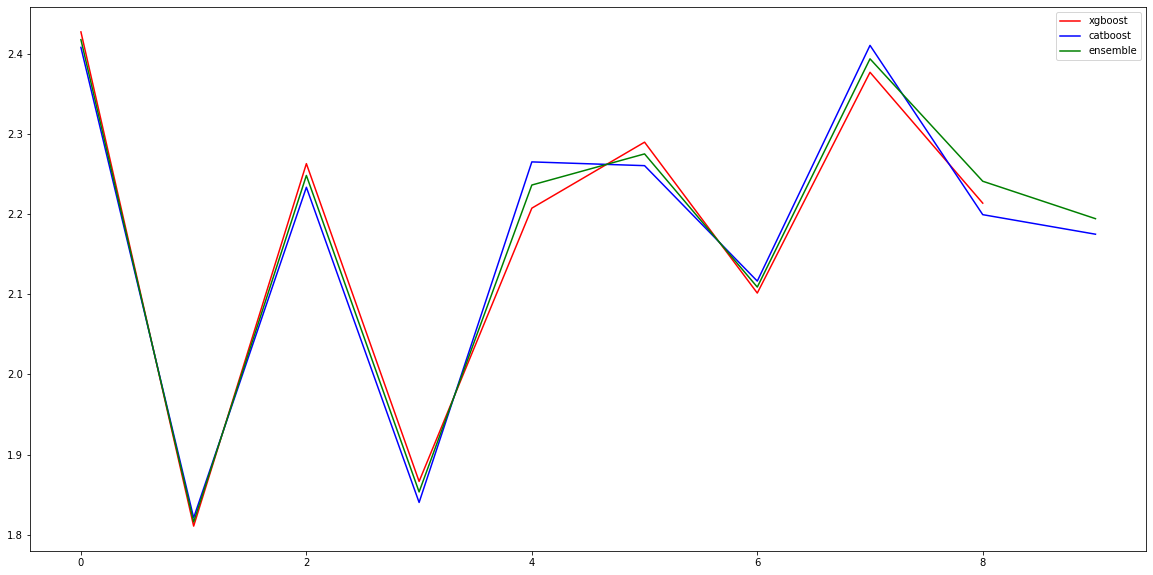

In [280]:
plt.figure(figsize=(20,10))
plt.plot(errxgboost,'r',label='xgboost')
plt.plot(errcatboost,'b',label='catboost')
plt.plot(errensemble,'g',label='ensemble')
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-278-180d093f7ca6>, line 3)

In [260]:
result_dict = dict()
val_pred = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])
final_err = 0
verbose = False
validationy = []
for i, (trn, val) in enumerate(fold) :
    print(i+1, "fold.    RMSE")
    trn_x = train.loc[trn, :]
    trn_y = y[trn]
    val_x = train.loc[val, :]
    val_y = y[val]
    
    fold_val_pred = []
    fold_test_pred = []
    fold_err = []
    
    #""" xgboost
    start = datetime.now()
#     print(list(test))
    result = xgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
   
    fold_val_pred.append(result['val']*0.2)
    validationy.append(val_y)
    fold_test_pred.append(result['test']*0.2)
#     rmse = np.sqrt(mean_squared_error(test, result['test']*0.2))
#     print("testshape", test.shape)
#     print("RMSE_test: %f" % (rmse))
    fold_err.append(result['error'])
    print("xgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')

1 fold.    RMSE
xgb model. 2.42787 (0m)
2 fold.    RMSE
xgb model. 1.81059 (0m)
3 fold.    RMSE
xgb model. 2.26332 (0m)
4 fold.    RMSE
xgb model. 1.86640 (0m)
5 fold.    RMSE
xgb model. 2.20771 (0m)
6 fold.    RMSE
xgb model. 2.29014 (0m)
7 fold.    RMSE
xgb model. 2.10166 (0m)
8 fold.    RMSE
xgb model. 2.37742 (0m)
9 fold.    RMSE
xgb model. 2.28308 (0m)
10 fold.    RMSE
xgb model. 2.21398 (0m)


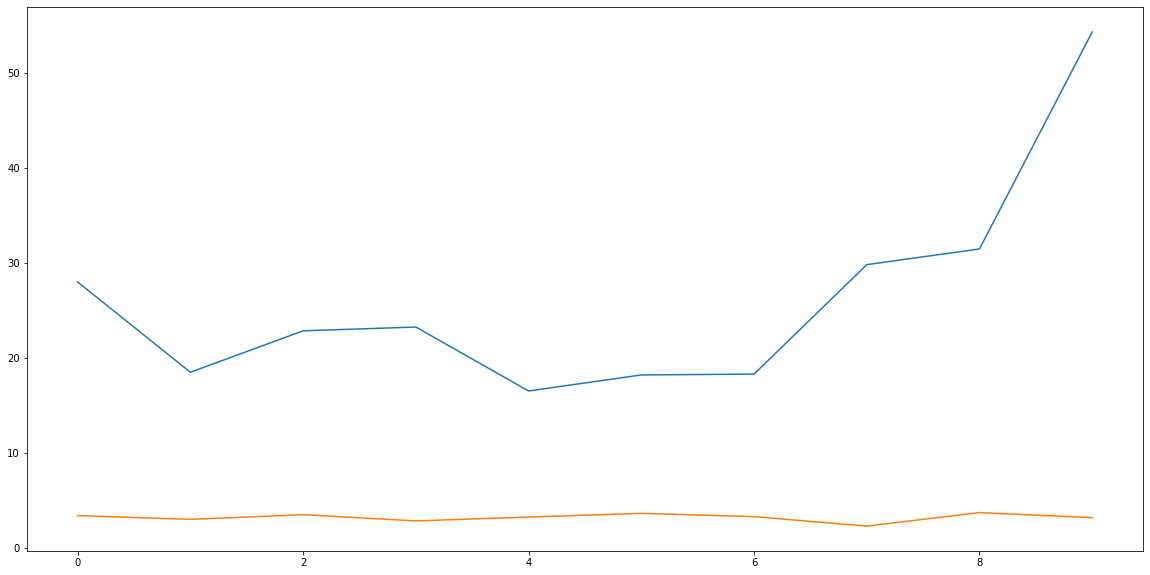

In [261]:
(plt.figure(figsize=(20,10)))
plt.plot(np.exp(fold_test_pred[0][0:10]))
plt.plot(fold_val_pred[0][0:10])
plt.show()

In [225]:
y_testing_revenue

array([nan, nan, nan, ..., nan, nan, nan])

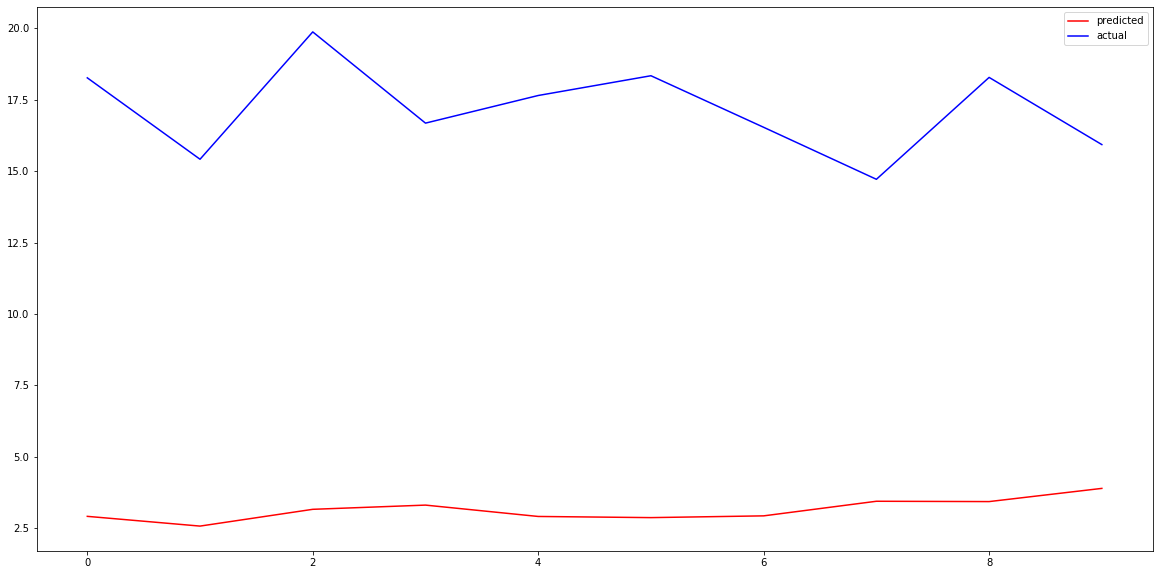

In [252]:
(plt.figure(figsize=(20,10)))
plt.plot((fold_test_pred[0][0:10]),'r',label='predicted')
plt.plot((validationy[9][0:10]),'b',label='actual')
plt.legend()

In [253]:
test['revenue']

KeyError: 'revenue'

In [25]:
X_train, X_test, y_train, y_test = train_test_split(train001, y001, test_size=0.33, random_state=42)


# num_cols = ["budget", "popularity", "runtime"]
# cat_cols = ["original_language"]
# X_train1 = X_train[num_cols]
# X_train2 = X_train[cat_cols]

# X_test1 = X_test[num_cols]
# X_test2 = X_test[cat_cols]


# X_train2 = pd.get_dummies(X_train2.original_language)
# X_test2 = pd.get_dummies(X_test2.original_language)


# scaler1 = StandardScaler()
# X_train1 = pd.DataFrame(scaler1.fit_transform(X_train1), columns = list(X_train1))
# X_test1 = pd.DataFrame(scaler1.transform(X_test1), columns=list(X_test1))

# scaler2 = StandardScaler()
# y_train = scaler2.fit_transform(pd.DataFrame(y_train))
# y_test = scaler2.transform(pd.DataFrame(y_test))

In [ ]:
### neural net

In [32]:
train

,budget,popularity,popularity2,rating,totalVotes,release_month,release_day,release_year,release_dayofweek,release_quarter,...,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Wild Bunch,Wildwood Enterprises,Working Title Films,production_companies_etc
0,16.454568,6.575393,10.400,5.0,482.0,2,20,2015,4.0,1.0,...,0,1,0,0,0,0,0,0,0,0
1,17.504390,8.248895,15.229,6.4,1528.0,8,6,2004,4.0,3.0,...,0,0,0,0,1,0,0,0,0,0
2,15.009433,64.299990,26.082,8.4,7314.0,10,10,2014,4.0,4.0,...,0,0,0,0,0,0,0,0,0,1
3,13.997833,3.174936,5.531,7.5,115.0,3,9,2012,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,1.148070,0.000,0.0,0.0,2,5,2009,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,13.815512,0.680000,0.000,5.0,1.0,16,10,1916,0.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4997,9.829626,0.600000,0.000,0.0,0.0,7,5,1916,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4998,10.020070,0.600000,0.000,0.0,0.0,15,12,1915,2.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4999,9.740321,0.600000,0.000,0.0,0.0,15,11,1914,6.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y

array([16.32630033, 18.37095922, 16.38751199, ..., 11.53701302,
       11.37399668, 13.81551156])

In [60]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(train, y, test_size=0.33, random_state=42)

In [61]:
X_train1

,budget,popularity,popularity2,rating,totalVotes,release_month,release_day,release_year,release_dayofweek,release_quarter,...,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Wild Bunch,Wildwood Enterprises,Working Title Films,production_companies_etc
835,0.000000,0.912730,1.849,5.3,11.0,3,8,1990,3.0,1.0,...,0,0,0,0,0,0,0,0,0,1
358,18.132999,7.970031,10.333,6.1,314.0,10,23,1998,4.0,4.0,...,0,0,0,0,0,1,0,0,0,1
138,0.000000,10.245682,7.784,5.8,923.0,2,5,2010,4.0,1.0,...,0,0,0,0,0,0,0,0,0,1
299,16.012735,1.808090,3.102,6.2,39.0,11,21,1991,3.0,4.0,...,0,0,0,0,0,0,0,0,0,1
1556,15.761421,6.904831,9.327,6.8,430.0,2,21,1996,2.0,1.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0.000000,5.605000,0.000,6.2,93.0,22,7,2004,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
466,16.648724,11.673366,12.202,6.7,1662.0,5,28,1982,4.0,2.0,...,0,1,0,0,0,0,0,0,0,0
3092,14.220976,2.776000,0.000,6.9,10.0,20,7,2018,4.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3772,15.201805,7.897000,0.000,7.5,360.0,24,9,2014,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
X_test1

,budget,popularity,popularity2,rating,totalVotes,release_month,release_day,release_year,release_dayofweek,release_quarter,...,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Wild Bunch,Wildwood Enterprises,Working Title Films,production_companies_etc
1501,16.705882,7.521346,7.114,7.5,592.0,12,15,1989,4.0,4.0,...,0,0,0,0,0,0,0,0,0,1
2586,0.000000,6.872888,0.000,0.0,0.0,6,23,1964,0.0,2.0,...,0,1,0,0,0,0,0,0,0,1
2653,15.687313,6.476534,7.223,6.8,210.0,7,24,1987,4.0,3.0,...,0,0,0,0,0,0,0,0,0,1
1055,0.000000,3.554939,7.127,5.1,86.0,5,3,2012,3.0,2.0,...,0,0,0,0,0,0,0,0,0,1
705,13.815512,17.911314,11.206,8.3,2675.0,8,1,1954,5.0,3.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,16.523561,6.777326,9.628,6.0,1054.0,9,20,2012,3.0,3.0,...,0,0,0,0,0,0,0,0,0,1
3896,0.000000,1.837000,0.000,5.5,11.0,12,4,2013,2.0,4.0,...,0,0,0,0,0,0,0,0,0,0
1627,0.000000,2.738000,2.454,5.6,36.0,3,18,1983,4.0,1.0,...,0,0,0,0,0,1,0,0,0,1
2873,15.071826,0.110065,0.600,6.3,31.0,3,13,2013,2.0,1.0,...,0,0,0,0,0,0,0,0,0,1


In [63]:
y_train1

array([14.08239383, 16.49432994, 14.935839  , ..., 14.93473495,
       15.29639257, 16.50896658])

In [64]:
y_test1

array([17.10497032, 16.33064205, 17.80847587, ..., 17.16189974,
       11.66014648, 12.40082084])

In [148]:
# from sklearn import preprocessing
# standardized_X = preprocessing.scale(X_train1)

ValueError: Input contains infinity or a value too large for dtype('float64').

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [128]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train1.shape[1], activation='tanh'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='sigmoid'))
# NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               26240     
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 59,521
Trainable params: 59,521
Non-trainable params: 0
_________________________________________________________________


In [129]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

204

In [130]:
NN_model.fit(X_train1, y_train1, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 2680 samples, validate on 670 samples
Epoch 1/500
2680/2680 [==============================] - 1s 214us/step - loss: 2.9586 - mean_absolute_error: 2.9586 - val_loss: 2.8409 - val_mean_absolute_error: 2.8409

Epoch 00001: val_loss improved from inf to 2.84094, saving model to Weights-001--2.84094.hdf5
Epoch 2/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8925 - mean_absolute_error: 2.8925 - val_loss: 2.8526 - val_mean_absolute_error: 2.8526

Epoch 00002: val_loss did not improve from 2.84094
Epoch 3/500
2680/2680 [==============================] - 0s 94us/step - loss: 2.8869 - mean_absolute_error: 2.8869 - val_loss: 2.8661 - val_mean_absolute_error: 2.8661

Epoch 00003: val_loss did not improve from 2.84094
Epoch 4/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8869 - mean_absolute_error: 2.8869 - val_loss: 2.8417 - val_mean_absolute_error: 2.8417

Epoch 00004: val_loss did not improve from 2.84094
Epoch 5/500
2680/2680 [======


Epoch 00073: val_loss did not improve from 2.83719
Epoch 74/500
2680/2680 [==============================] - 0s 97us/step - loss: 2.8526 - mean_absolute_error: 2.8526 - val_loss: 2.8433 - val_mean_absolute_error: 2.8433

Epoch 00074: val_loss did not improve from 2.83719
Epoch 75/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8514 - mean_absolute_error: 2.8514 - val_loss: 2.8386 - val_mean_absolute_error: 2.8386

Epoch 00075: val_loss did not improve from 2.83719
Epoch 76/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8565 - mean_absolute_error: 2.8565 - val_loss: 2.8525 - val_mean_absolute_error: 2.8525

Epoch 00076: val_loss did not improve from 2.83719
Epoch 77/500
2680/2680 [==============================] - 0s 97us/step - loss: 2.8594 - mean_absolute_error: 2.8594 - val_loss: 2.8485 - val_mean_absolute_error: 2.8485

Epoch 00077: val_loss did not improve from 2.83719
Epoch 78/500
2680/2680 [==============================] - 0s 96u


Epoch 00110: val_loss did not improve from 2.83718
Epoch 111/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8536 - mean_absolute_error: 2.8536 - val_loss: 2.8401 - val_mean_absolute_error: 2.8401

Epoch 00111: val_loss did not improve from 2.83718
Epoch 112/500
2680/2680 [==============================] - 0s 92us/step - loss: 2.8470 - mean_absolute_error: 2.8470 - val_loss: 2.8609 - val_mean_absolute_error: 2.8609

Epoch 00112: val_loss did not improve from 2.83718
Epoch 113/500
2680/2680 [==============================] - 0s 97us/step - loss: 2.8538 - mean_absolute_error: 2.8538 - val_loss: 2.8430 - val_mean_absolute_error: 2.8430

Epoch 00113: val_loss did not improve from 2.83718
Epoch 114/500
2680/2680 [==============================] - 0s 94us/step - loss: 2.8474 - mean_absolute_error: 2.8474 - val_loss: 2.8393 - val_mean_absolute_error: 2.8393

Epoch 00114: val_loss did not improve from 2.83718
Epoch 115/500
2680/2680 [==============================] - 0


Epoch 00147: val_loss did not improve from 2.83718
Epoch 148/500
2680/2680 [==============================] - 0s 94us/step - loss: 2.8530 - mean_absolute_error: 2.8530 - val_loss: 2.8384 - val_mean_absolute_error: 2.8384

Epoch 00148: val_loss did not improve from 2.83718
Epoch 149/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8525 - mean_absolute_error: 2.8525 - val_loss: 2.8402 - val_mean_absolute_error: 2.8402

Epoch 00149: val_loss did not improve from 2.83718
Epoch 150/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8573 - mean_absolute_error: 2.8573 - val_loss: 2.8408 - val_mean_absolute_error: 2.8408

Epoch 00150: val_loss did not improve from 2.83718
Epoch 151/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8631 - mean_absolute_error: 2.8631 - val_loss: 2.8376 - val_mean_absolute_error: 2.8376

Epoch 00151: val_loss did not improve from 2.83718
Epoch 152/500
2680/2680 [==============================] - 0


Epoch 00184: val_loss did not improve from 2.83718
Epoch 185/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8549 - mean_absolute_error: 2.8549 - val_loss: 2.8372 - val_mean_absolute_error: 2.8372

Epoch 00185: val_loss did not improve from 2.83718
Epoch 186/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8522 - mean_absolute_error: 2.8522 - val_loss: 2.8537 - val_mean_absolute_error: 2.8537

Epoch 00186: val_loss did not improve from 2.83718
Epoch 187/500
2680/2680 [==============================] - 0s 97us/step - loss: 2.8570 - mean_absolute_error: 2.8570 - val_loss: 2.8375 - val_mean_absolute_error: 2.8375

Epoch 00187: val_loss did not improve from 2.83718
Epoch 188/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8541 - mean_absolute_error: 2.8541 - val_loss: 2.8386 - val_mean_absolute_error: 2.8386

Epoch 00188: val_loss did not improve from 2.83718
Epoch 189/500
2680/2680 [==============================] - 0


Epoch 00221: val_loss did not improve from 2.83718
Epoch 222/500
2680/2680 [==============================] - 0s 93us/step - loss: 2.8600 - mean_absolute_error: 2.8600 - val_loss: 2.8430 - val_mean_absolute_error: 2.8430

Epoch 00222: val_loss did not improve from 2.83718
Epoch 223/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8546 - mean_absolute_error: 2.8546 - val_loss: 2.8535 - val_mean_absolute_error: 2.8535

Epoch 00223: val_loss did not improve from 2.83718
Epoch 224/500
2680/2680 [==============================] - 0s 98us/step - loss: 2.8588 - mean_absolute_error: 2.8588 - val_loss: 2.8372 - val_mean_absolute_error: 2.8372

Epoch 00224: val_loss did not improve from 2.83718
Epoch 225/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8605 - mean_absolute_error: 2.8605 - val_loss: 2.8421 - val_mean_absolute_error: 2.8421

Epoch 00225: val_loss did not improve from 2.83718
Epoch 226/500
2680/2680 [==============================] - 0

2680/2680 [==============================] - 0s 95us/step - loss: 2.8544 - mean_absolute_error: 2.8544 - val_loss: 2.8378 - val_mean_absolute_error: 2.8378

Epoch 00295: val_loss did not improve from 2.83718
Epoch 296/500
2680/2680 [==============================] - 0s 101us/step - loss: 2.8601 - mean_absolute_error: 2.8601 - val_loss: 2.8473 - val_mean_absolute_error: 2.8473

Epoch 00296: val_loss did not improve from 2.83718
Epoch 297/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8633 - mean_absolute_error: 2.8633 - val_loss: 2.8443 - val_mean_absolute_error: 2.8443

Epoch 00297: val_loss did not improve from 2.83718
Epoch 298/500
2680/2680 [==============================] - 0s 100us/step - loss: 2.8518 - mean_absolute_error: 2.8518 - val_loss: 2.8617 - val_mean_absolute_error: 2.8617

Epoch 00298: val_loss did not improve from 2.83718
Epoch 299/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8629 - mean_absolute_error: 2.8629 - val_l

2680/2680 [==============================] - 0s 93us/step - loss: 2.8534 - mean_absolute_error: 2.8534 - val_loss: 2.8401 - val_mean_absolute_error: 2.8401

Epoch 00332: val_loss did not improve from 2.83718
Epoch 333/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8512 - mean_absolute_error: 2.8512 - val_loss: 2.8374 - val_mean_absolute_error: 2.8374

Epoch 00333: val_loss did not improve from 2.83718
Epoch 334/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8582 - mean_absolute_error: 2.8582 - val_loss: 2.8399 - val_mean_absolute_error: 2.8399

Epoch 00334: val_loss did not improve from 2.83718
Epoch 335/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8617 - mean_absolute_error: 2.8617 - val_loss: 2.8407 - val_mean_absolute_error: 2.8407

Epoch 00335: val_loss did not improve from 2.83718
Epoch 336/500
2680/2680 [==============================] - 0s 94us/step - loss: 2.8590 - mean_absolute_error: 2.8590 - val_los

2680/2680 [==============================] - 0s 97us/step - loss: 2.8568 - mean_absolute_error: 2.8568 - val_loss: 2.8664 - val_mean_absolute_error: 2.8664

Epoch 00369: val_loss did not improve from 2.83718
Epoch 370/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8611 - mean_absolute_error: 2.8611 - val_loss: 2.8377 - val_mean_absolute_error: 2.8377

Epoch 00370: val_loss did not improve from 2.83718
Epoch 371/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8632 - mean_absolute_error: 2.8632 - val_loss: 2.8450 - val_mean_absolute_error: 2.8450

Epoch 00371: val_loss did not improve from 2.83718
Epoch 372/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8614 - mean_absolute_error: 2.8614 - val_loss: 2.8377 - val_mean_absolute_error: 2.8377

Epoch 00372: val_loss did not improve from 2.83718
Epoch 373/500
2680/2680 [==============================] - 0s 93us/step - loss: 2.8539 - mean_absolute_error: 2.8539 - val_los

2680/2680 [==============================] - 0s 97us/step - loss: 2.8527 - mean_absolute_error: 2.8527 - val_loss: 2.8501 - val_mean_absolute_error: 2.8501

Epoch 00406: val_loss did not improve from 2.83718
Epoch 407/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8560 - mean_absolute_error: 2.8560 - val_loss: 2.8402 - val_mean_absolute_error: 2.8402

Epoch 00407: val_loss did not improve from 2.83718
Epoch 408/500
2680/2680 [==============================] - 0s 97us/step - loss: 2.8558 - mean_absolute_error: 2.8558 - val_loss: 2.8392 - val_mean_absolute_error: 2.8392

Epoch 00408: val_loss did not improve from 2.83718
Epoch 409/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8606 - mean_absolute_error: 2.8606 - val_loss: 2.8416 - val_mean_absolute_error: 2.8416

Epoch 00409: val_loss did not improve from 2.83718
Epoch 410/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8521 - mean_absolute_error: 2.8521 - val_los

2680/2680 [==============================] - 0s 94us/step - loss: 2.8544 - mean_absolute_error: 2.8544 - val_loss: 2.8375 - val_mean_absolute_error: 2.8375

Epoch 00443: val_loss did not improve from 2.83718
Epoch 444/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8542 - mean_absolute_error: 2.8542 - val_loss: 2.8486 - val_mean_absolute_error: 2.8486

Epoch 00444: val_loss did not improve from 2.83718
Epoch 445/500
2680/2680 [==============================] - 0s 94us/step - loss: 2.8549 - mean_absolute_error: 2.8549 - val_loss: 2.8407 - val_mean_absolute_error: 2.8407

Epoch 00445: val_loss did not improve from 2.83718
Epoch 446/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8550 - mean_absolute_error: 2.8550 - val_loss: 2.8442 - val_mean_absolute_error: 2.8442

Epoch 00446: val_loss did not improve from 2.83718
Epoch 447/500
2680/2680 [==============================] - 0s 96us/step - loss: 2.8554 - mean_absolute_error: 2.8554 - val_los

2680/2680 [==============================] - 0s 98us/step - loss: 2.8529 - mean_absolute_error: 2.8529 - val_loss: 2.8484 - val_mean_absolute_error: 2.8484

Epoch 00480: val_loss did not improve from 2.83718
Epoch 481/500
2680/2680 [==============================] - 0s 94us/step - loss: 2.8530 - mean_absolute_error: 2.8530 - val_loss: 2.8913 - val_mean_absolute_error: 2.8913

Epoch 00481: val_loss did not improve from 2.83718
Epoch 482/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8550 - mean_absolute_error: 2.8550 - val_loss: 2.8374 - val_mean_absolute_error: 2.8374

Epoch 00482: val_loss did not improve from 2.83718
Epoch 483/500
2680/2680 [==============================] - 0s 95us/step - loss: 2.8534 - mean_absolute_error: 2.8534 - val_loss: 2.8393 - val_mean_absolute_error: 2.8393

Epoch 00483: val_loss did not improve from 2.83718
Epoch 484/500
2680/2680 [==============================] - 0s 93us/step - loss: 2.8587 - mean_absolute_error: 2.8587 - val_los

In [131]:
# Load wights file of the best model :
# wights_file = 'Weights-478--18738.19831.hdf5' # choose the best checkpoint 
# NN_model.load_weights(wights_file) # load it

NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [132]:
# def make_submission(prediction, sub_name):
#   my_submission = pd.DataFrame({'Id':pd.read_csv('test.csv').Id,'SalePrice':prediction})
#   my_submission.to_csv('{}.csv'.format(sub_name),index=False)
#   print('A submission file has been made')

predictions = NN_model.predict(X_test1)
# make_submission(predictions[:,0],'submission(NN).csv')

In [141]:
predictions

array([[15.861867],
       [15.861867],
       [15.861867],
       ...,
       [15.861867],
       [15.861867],
       [15.861867]], dtype=float32)

In [142]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# rms = sqrt(mean_squared_error(predictions, y_test1))

In [143]:
rms

4.1173229900176835

In [144]:
# sub = pd.read_csv('sample_submission.csv')
# df_sub = pd.DataFrame()
# df_sub['id'] = sub['id']

temp = np.expm1(y_test1)
#print(df_sub['revenue'])
# df_sub.to_csv("submission.csv", index=False)

In [145]:
temp

array([26828364.99999999, 12368233.99999999, 54215416.        , ...,
       28399999.99999998,   115860.        ,   243000.        ])

In [146]:
np.expm1(predictions)*3

array([[23218946.],
       [23218946.],
       [23218946.],
       ...,
       [23218946.],
       [23218946.],
       [23218946.]], dtype=float32)

In [139]:
y_test1

array([17.10497032, 16.33064205, 17.80847587, ..., 17.16189974,
       11.66014648, 12.40082084])

In [140]:
predictions

array([[15.861867],
       [15.861867],
       [15.861867],
       ...,
       [15.861867],
       [15.861867],
       [15.861867]], dtype=float32)